# Shapefile Demo

This notebook demonstrates how to use shapefiles to "clip" larger regions. The code creates a simple median mosaic and then uses a stored shapefile to "clip" the results. Portions of this code could be used in other notebooks for shapefile masking other products. 

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
%matplotlib inline

# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

# Load Data Cube Configuration
import datacube
import utils.data_cube_utilities.data_access_api as dc_api  

import xarray as xr  
import numpy as np
import matplotlib.pyplot as plt

api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')
dc = api.dc

## Choose Product and Analysis Extents

In [2]:
# Select a Product and Platform
product = "ls8_lasrc_ghana"
platform = "LANDSAT_8"

# Ankobra River Basin = Entire Bounding Region
latitude = (5.198, 5.695)
longitude = (-2.275, -1.750)

# Time Period
time_extents = ('2019-01-01', '2019-12-31')

In [3]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## <span id="load_data">Load and Clean Data and create a Median Mosaic [&#9652;](#top)</span>

In [4]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [5]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 1845, longitude: 1949, time: 46)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-06T10:21:44 ... 2019-12-31T10:28:16
  * latitude   (latitude) float64 5.695 5.695 5.695 5.694 ... 5.199 5.198 5.198
  * longitude  (longitude) float64 -2.275 -2.275 -2.274 ... -1.751 -1.75 -1.75
Data variables:
    red        (time, latitude, longitude) int16 522 507 488 ... -9999 -9999
    green      (time, latitude, longitude) int16 631 628 613 ... -9999 -9999
    blue       (time, latitude, longitude) int16 330 331 328 ... -9999 -9999
    nir        (time, latitude, longitude) int16 3103 3056 2857 ... -9999 -9999
    swir1      (time, latitude, longitude) int16 1978 1944 1852 ... -9999 -9999
    swir2      (time, latitude, longitude) int16 964 937 901 ... -9999 -9999
    pixel_qa   (time, latitude, longitude) int32 322 322 322 322 322 ... 1 1 1 1
Attributes:
    crs:      EPSG:4326

In [6]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)

In [7]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic, create_max_ndvi_mosaic
from utils.data_cube_utilities.dc_rgb import rgb
median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)

## Shapefile Masking

In [8]:
# Load the shapefile from a folder on the user system
SHAPE_FILE_PATH = "data/Ghana/Prestea.shp"

In [9]:
import fiona
import xarray as xr 
from rasterio.features import geometry_mask
import shapely
from shapely.ops import transform
from shapely.geometry import shape
from functools import partial
import pyproj

def shapefile_mask(dataset: xr.Dataset, shapefile) -> np.array:
    """Extracts a mask from a shapefile using dataset latitude and longitude extents.

    Args:
        dataset (xarray.Dataset): The dataset with the latitude and longitude extents.
        shapefile (string): The shapefile to be used for extraction.

    Returns:
        A boolean mask array.
    """
    with fiona.open(shapefile, 'r') as source:
        collection = list(source)
        geometries = []
        for feature in collection:
            geom = shape(feature['geometry'])
            project = partial(
                pyproj.transform,
                pyproj.Proj(init=source.crs['init']), # source crs
                pyproj.Proj(init='epsg:4326')) # destination crs
            geom = transform(project, geom)  # apply projection
            geometries.append(geom)
        geobox = dataset.geobox
        mask = geometry_mask(
            geometries,
            out_shape=geobox.shape,
            transform=geobox.affine,
            all_touched=True,
            invert=True)
    return mask

In [10]:
mask = shapefile_mask(cleaned_dataset, SHAPE_FILE_PATH)
masked_composite = median_composite.where(mask)

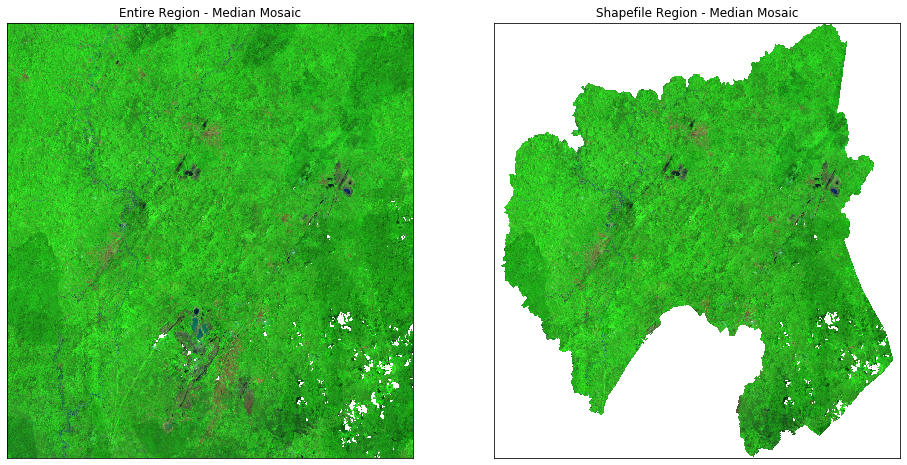

In [11]:
# Show Entire Region and Shapefile Region

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
median_rgb = median_composite[['swir2', 'nir', 'green']].to_array()
median_rgb_shapefile = masked_composite[['swir2', 'nir', 'green']].to_array()
median_rgb.plot.imshow(ax=ax[0], vmin=0, vmax=5000)
median_rgb_shapefile.plot.imshow(ax=ax[1], vmin=0, vmax=5000)
ax[0].set_title('Entire Region - Median Mosaic'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Shapefile Region - Median Mosaic'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()